In [36]:
# Import Libraries
from textblob import TextBlob
import sys
import tweepy
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import nltk
import pycountry
import re
import string
from wordcloud import WordCloud, STOPWORDS
from PIL import Image
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from langdetect import detect
from nltk.stem import SnowballStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('vader_lexicon')
from IPython.display import display


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Robotics\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [37]:
# Authentication
consumerKey = "jLsJDtWU8yD5tZlcmwlzYnGjj"
consumerSecret = "Y236WRUhs5ylGfcZwjmabwPRWwedThHVB8gFVBPC3oTNAbRnCz"
accessToken = "964316780993933313-ZJOdE1MRMA8WyqZoNajtj0EWy4KQVDI"
accessTokenSecret = "qMOuqbyZmKXQTVXGFofwriLZpZn5zAAwGjsw0Wlft7M0a"
auth = tweepy.OAuthHandler(consumerKey, consumerSecret)
auth.set_access_token(accessToken, accessTokenSecret)
api = tweepy.API(auth)

In [38]:
#Sentiment Analysis
def percentage(part,whole):
 return 100 * float(part)/float(whole)
keyword = input('Please enter keyword or hashtag to search: ')
noOfTweet = int(input ('Please enter how many tweets to analyze: '))
tweets = tweepy.Cursor(api.search_tweets, q=keyword).items(noOfTweet)
positive = 0
negative = 0
neutral = 0
polarity = 0
tweet_list = []
neutral_list = []
negative_list = []
positive_list = []
for tweet in tweets:
 
    #print(tweet.text)
    tweet_list.append(tweet.text)
    analysis = TextBlob(tweet.text)
    score = SentimentIntensityAnalyzer().polarity_scores(tweet.text)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    polarity += analysis.sentiment.polarity
    
    if neg > pos:
        negative_list.append(tweet.text)
        negative += 1
    elif pos > neg:
        positive_list.append(tweet.text)
        positive += 1
    
    elif pos == neg:
        neutral_list.append(tweet.text)
        neutral += 1
positive = percentage(positive, noOfTweet)
negative = percentage(negative, noOfTweet)
neutral = percentage(neutral, noOfTweet)
polarity = percentage(polarity, noOfTweet)
positive = format(positive, '.1f')
negative = format(negative, '.1f')
neutral = format(neutral, '.1f')

TooManyRequests: 429 Too Many Requests
88 - Rate limit exceeded

In [ ]:
#Number of Tweets (Total, Positive, Negative, Neutral)
tweet_list = pd.DataFrame(tweet_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)
print('total number: ',len(tweet_list))
print('positive number: ',len(positive_list))
print('negative number: ', len(negative_list))
print('neutral number: ',len(neutral_list))

total number:  100
positive number:  22
negative number:  44
neutral number:  34


In [ ]:
#Cleaning Text (RT, Punctuation etc)

#Creating new dataframe and new features
tw_list = pd.DataFrame(tweet_list)
tw_list["text"] = tw_list[0]

#Removing RT, Punctuation etc
remove_rt = lambda x: re.sub('RT @\w+: '," ",x)
rt = lambda x: re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ", x)
tw_list["text"] = tw_list.text.map(remove_rt).map(rt)
tw_list["text"] = tw_list.text.str.lower()
tw_list.head(10)

TypeError: 'str' object cannot be interpreted as an integer

In [ ]:
#Calculating Negative, Positive, Neutral and Compound values
tw_list[['polarity', 'subjectivity']] = tw_list['text'].apply(lambda Text: pd.Series(TextBlob(Text).sentiment))
for index, row in tw_list['text'].iteritems():
    score = SentimentIntensityAnalyzer().polarity_scores(row)
    neg = score['neg']
    neu = score['neu']
    pos = score['pos']
    comp = score['compound']
    if neg > pos:
        tw_list.loc[index, 'sentiment'] = "negative"
    elif pos > neg:
        tw_list.loc[index, 'sentiment'] = "positive"
    else:
        tw_list.loc[index, 'sentiment'] = "neutral"
        tw_list.loc[index, 'neg'] = neg
        tw_list.loc[index, 'neu'] = neu
        tw_list.loc[index, 'pos'] = pos
        tw_list.loc[index, 'compound'] = comp
tw_list.head(10)
#Creating new data frames for all sentiments (positive, negative and neutral)
tw_list_negative = tw_list[tw_list["sentiment"]=="negative"]
tw_list_positive = tw_list[tw_list["sentiment"]=="positive"]
tw_list_neutral = tw_list[tw_list["sentiment"]=="neutral"]

In [ ]:
def count_values_in_column(data,feature):
    total=data.loc[:,feature].value_counts(dropna=False)
    percentage=round(data.loc[:,feature].value_counts(dropna=False,normalize=True)*100,2)
    return pd.concat([total,percentage],axis=1,keys=['Total','Percentage'])
#Count_values for sentiment
count_values_in_column(tw_list,"sentiment")

,Total,Percentage
negative,33,40.74
neutral,24,29.63
positive,24,29.63


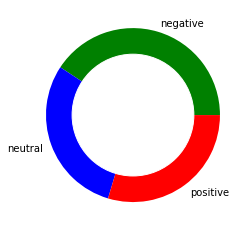

In [ ]:
# create data for Pie Chart
pc = count_values_in_column(tw_list,'sentiment')
names= pc.index
size=pc['Percentage']
 
# Create a circle for the center of the plot
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(size, labels=names, colors=['green','blue','red'])
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
def create_wordcloud(text):
    mask = np.array(Image.open('cloud.png'))
    stopwords = set(STOPWORDS)
    wc = WordCloud(background_color='white',
    mask = mask,
    max_words=3000,
    stopwords=stopwords,
    repeat=True)
    wc.generate(str(text))
    wc.to_file("wc.png")
    print("Word Cloud Saved Successfully")
    path="wc.png"
    display(Image.open(path))

Word Cloud Saved Successfully


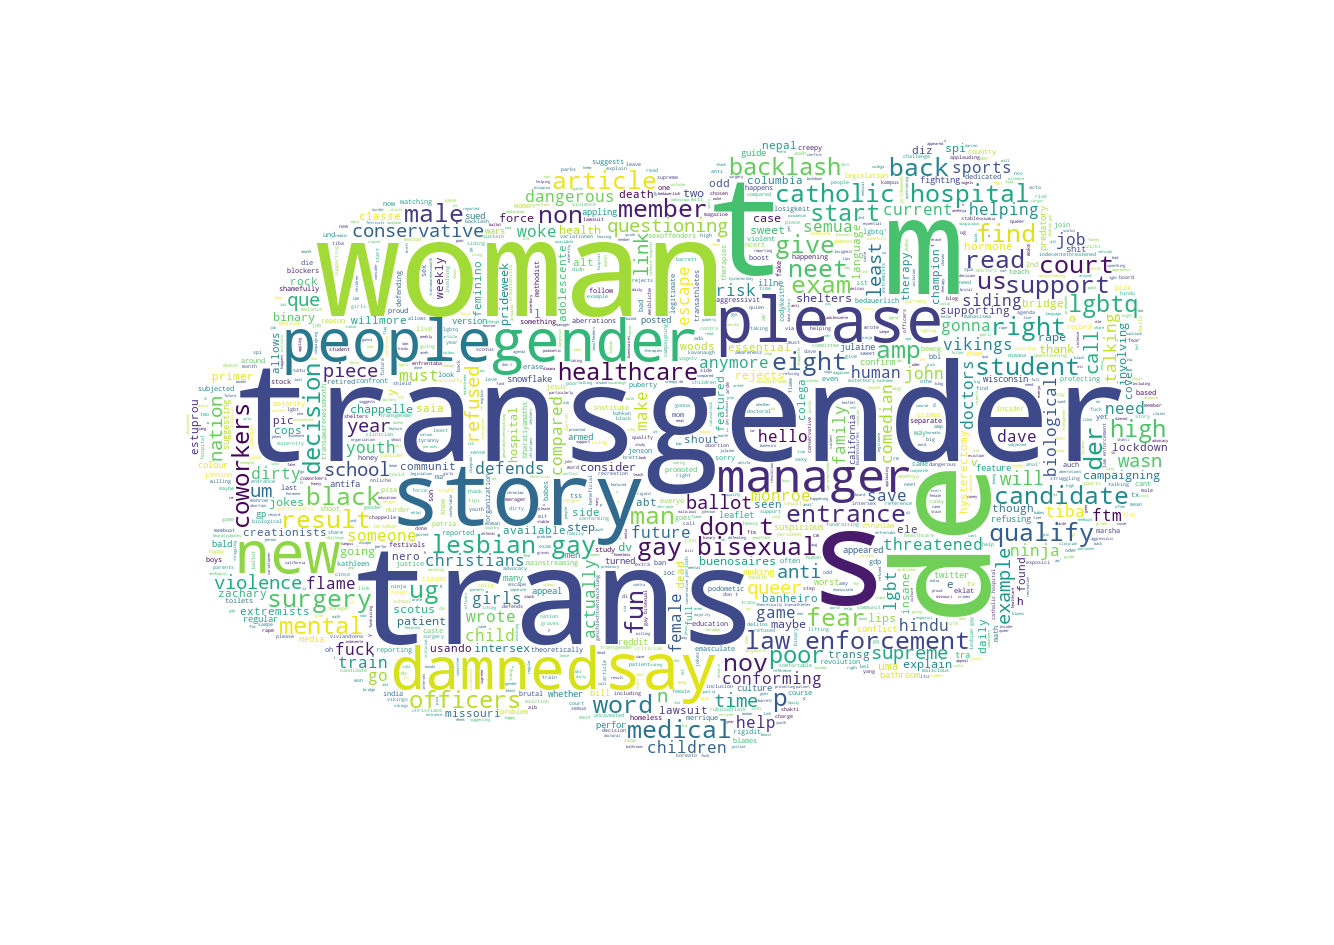

In [ ]:
create_wordcloud(tw_list['text'].values)

Word Cloud Saved Successfully


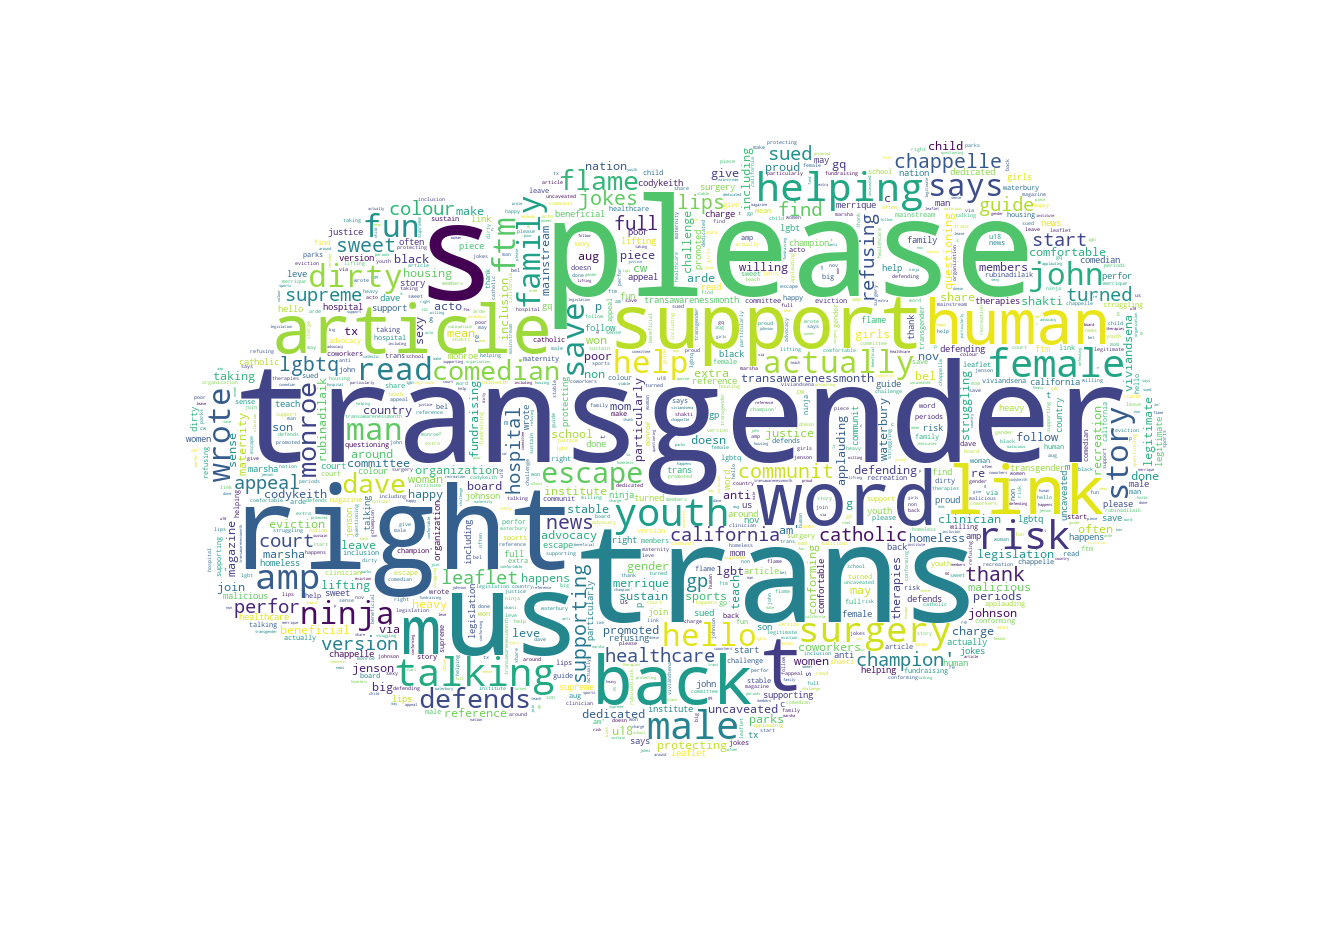

In [ ]:

#Creating wordcloud for positive sentiment
create_wordcloud(tw_list_positive["text"].values)

Word Cloud Saved Successfully


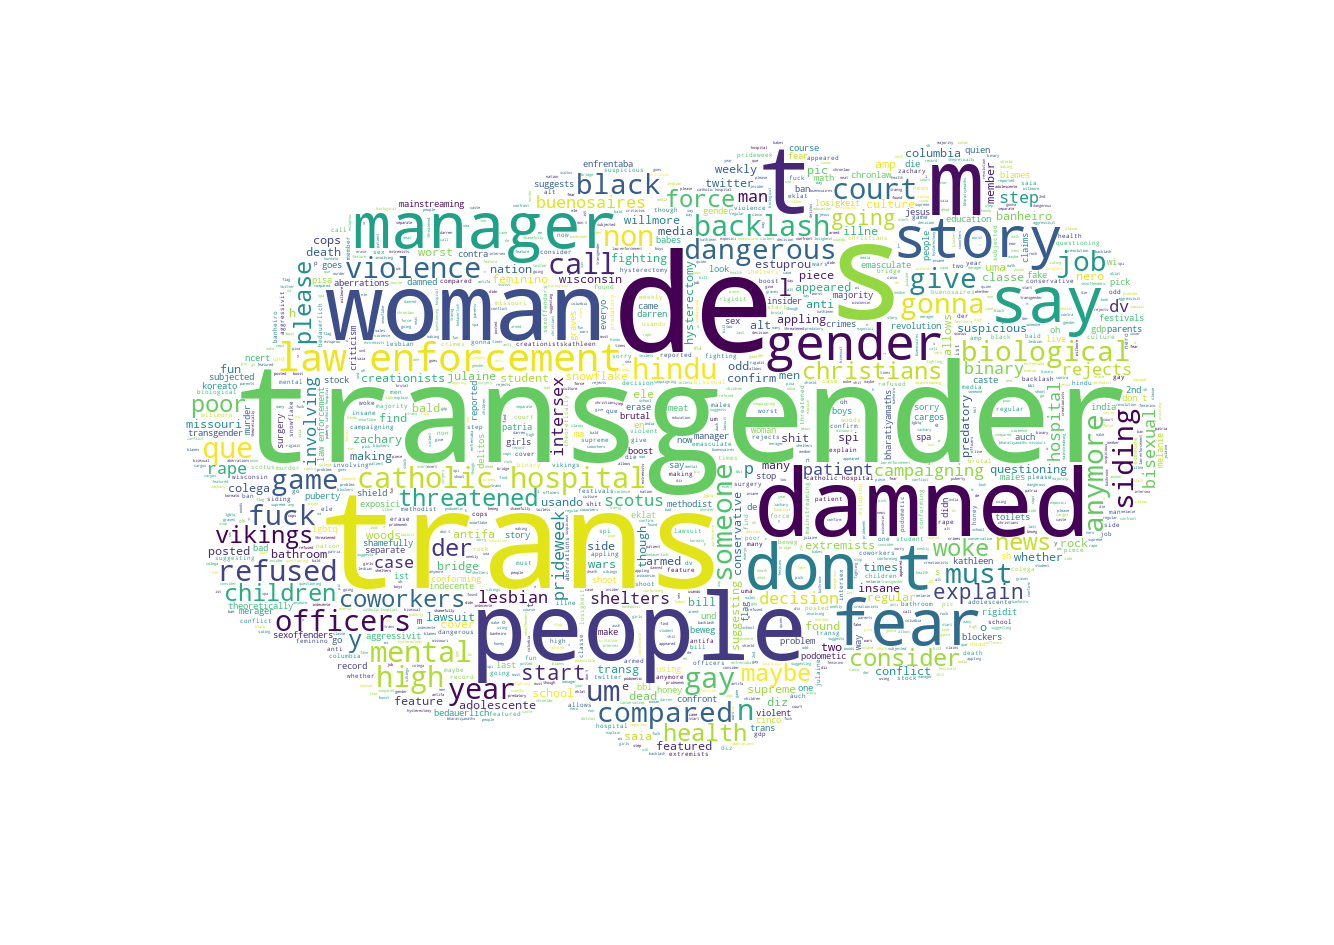

In [ ]:

#Creating wordcloud for negative sentiment
create_wordcloud(tw_list_negative["text"].values)

Word Cloud Saved Successfully


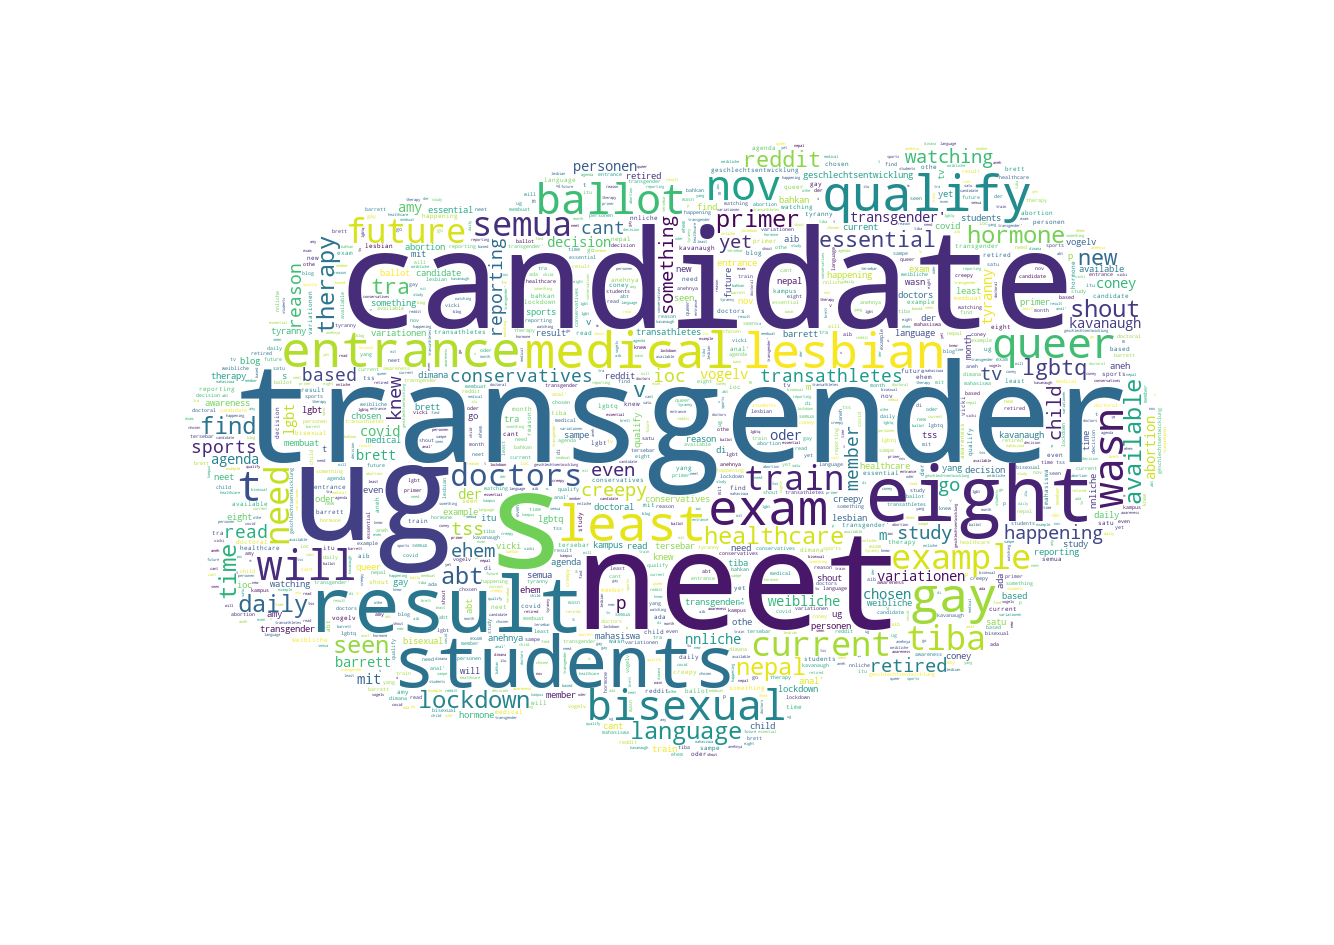

In [ ]:
#Creating wordcloud for neutral sentiment
create_wordcloud(tw_list_neutral["text"].values)